## Mounting drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading data

In [2]:
import glob
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

folder_npy = '/content/drive/My Drive/googledrive_segmentation/ct-normal-slices-test'

file_paths = glob.glob(os.path.join(folder_npy, '*.npy'))
file_paths.sort()
print(file_paths)
print(len(file_paths))

['/content/drive/My Drive/googledrive_segmentation/ct-normal-slices-test/T_0001_300_280_362_T_001.npy', '/content/drive/My Drive/googledrive_segmentation/ct-normal-slices-test/T_0002_266_273_365_T_002.npy', '/content/drive/My Drive/googledrive_segmentation/ct-normal-slices-test/T_0003_286_267_310_T_003.npy', '/content/drive/My Drive/googledrive_segmentation/ct-normal-slices-test/T_0004_296_387_387_T_004.npy', '/content/drive/My Drive/googledrive_segmentation/ct-normal-slices-test/T_0005_242_275_340_T_005.npy', '/content/drive/My Drive/googledrive_segmentation/ct-normal-slices-test/T_0006_304_282_384_T_006.npy', '/content/drive/My Drive/googledrive_segmentation/ct-normal-slices-test/T_0007_272_295_372_T_007.npy', '/content/drive/My Drive/googledrive_segmentation/ct-normal-slices-test/T_0008_268_289_352_T_008.npy', '/content/drive/My Drive/googledrive_segmentation/ct-normal-slices-test/T_0009_318_274_379_T_009.npy', '/content/drive/My Drive/googledrive_segmentation/ct-normal-slices-test/

## BCDU-net

In [3]:
from __future__ import division
from keras.models import Model
from keras.layers import Input
from keras.layers import concatenate
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import UpSampling2D
from keras.layers import Reshape
from keras.layers import core
from keras.layers import Dropout
from keras.layers import Conv2DTranspose
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import ConvLSTM2D
from keras.optimizers import Adam
    
def BCDU_net_D3(input_size = (128,128,1)):
    N = input_size[0]
    inputs = Input(input_size) 
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    # D1
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)     
    conv4_1 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4_1 = Dropout(0.5)(conv4_1)
    # D2
    conv4_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4_1)     
    conv4_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_2)
    conv4_2 = Dropout(0.5)(conv4_2)
    # D3
    merge_dense = concatenate([conv4_2,drop4_1], axis = 3)
    conv4_3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge_dense)     
    conv4_3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_3)
    drop4_3 = Dropout(0.5)(conv4_3)
    
    up6 = Conv2DTranspose(128, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(drop4_3)
    up6 = BatchNormalization(axis=3)(up6)
    up6 = Activation('relu')(up6)

    x1 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 128))(drop3)
    x2 = Reshape(target_shape=(1, np.int32(N/4), np.int32(N/4), 128))(up6)
    merge6  = concatenate([x1,x2], axis = 1) 
    merge6 = ConvLSTM2D(filters = 64, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal')(merge6)
            
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2DTranspose(64, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv6)
    up7 = BatchNormalization(axis=3)(up7)
    up7 = Activation('relu')(up7)

    x1 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 64))(conv2)
    x2 = Reshape(target_shape=(1, np.int32(N/2), np.int32(N/2), 64))(up7)
    merge7  = concatenate([x1,x2], axis = 1) 
    merge7 = ConvLSTM2D(filters = 32, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge7)
        
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2DTranspose(32, kernel_size=2, strides=2, padding='same',kernel_initializer = 'he_normal')(conv7)
    up8 = BatchNormalization(axis=3)(up8)
    up8 = Activation('relu')(up8)    

    x1 = Reshape(target_shape=(1, N, N, 32))(conv1)
    x2 = Reshape(target_shape=(1, N, N, 32))(up8)
    merge8  = concatenate([x1,x2], axis = 1) 
    merge8 = ConvLSTM2D(filters = 16, kernel_size=(3, 3), padding='same', return_sequences = False, go_backwards = True,kernel_initializer = 'he_normal' )(merge8)    
    
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv9 = Conv2D(1, 1, activation = 'sigmoid')(conv8)

    model = Model(inputs, conv9)
    return model

In [4]:
model = BCDU_net_D3(input_size = (128,128,1))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [5]:
model.load_weights('/content/drive/MyDrive/googledrive_segmentation/weight_half_lung_noisy_unet.hdf5')

### Resizing the slices for BCDUNET model

In [6]:
from skimage.transform import resize

100%|██████████| 15/15 [03:14<00:00, 12.97s/it]


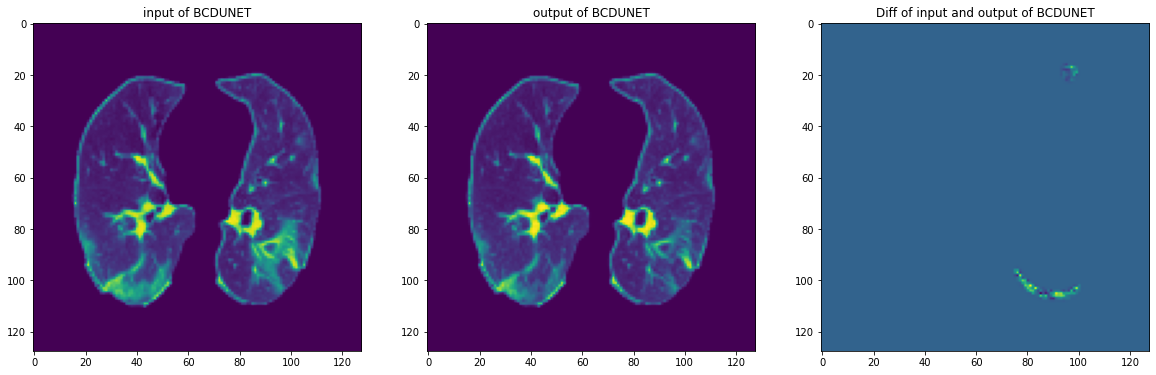

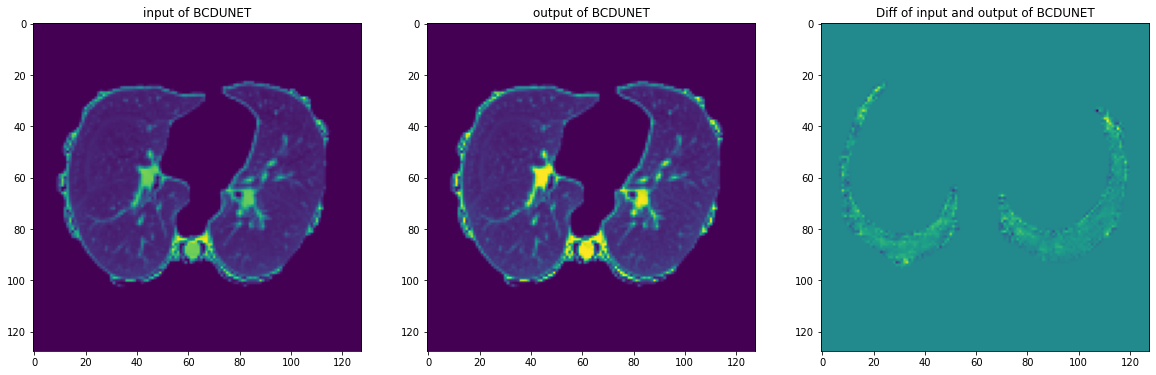

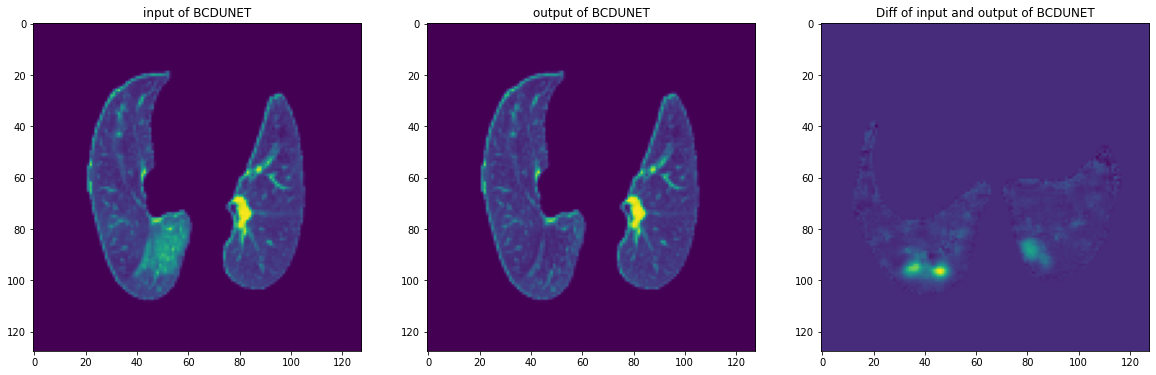

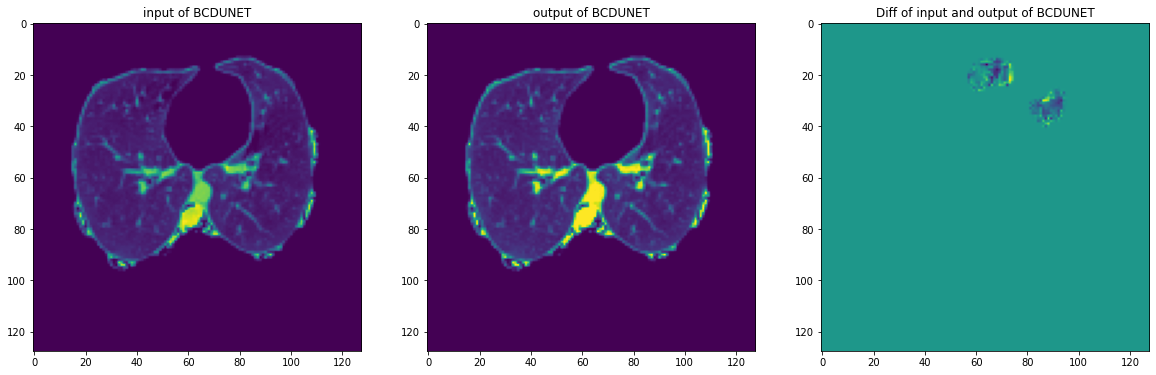

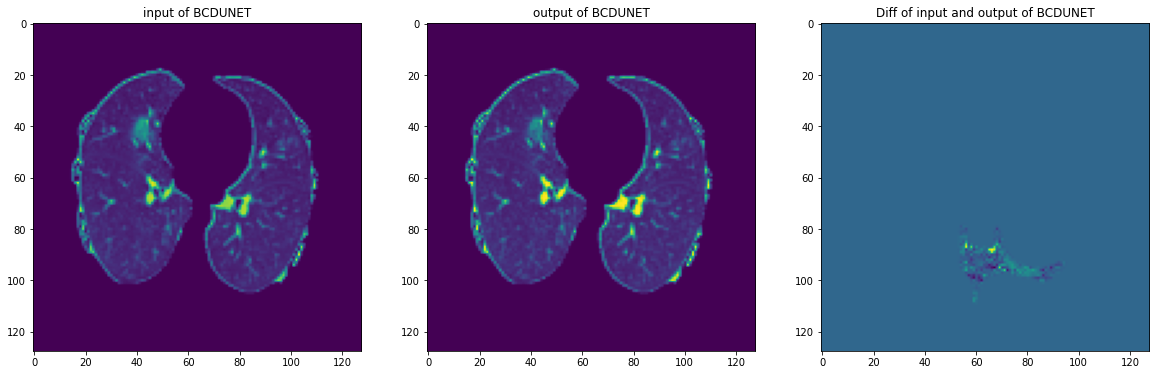

In [7]:
from scipy import signal
from tqdm import tqdm
dataset = np.zeros((len(file_paths),50,128,128))
counter = 0
for j in tqdm(file_paths):
    # print(j)
    CT = np.load(j)
    CT_resized = resize(CT, (CT.shape[0],128, 128),anti_aliasing=True)
    out = model.predict(np.reshape(CT_resized,(CT_resized.shape[0],CT_resized.shape[1],CT_resized.shape[2],1)))
    c = CT_resized-out[:,:,:,0]
    diff = resize(c,(50,128,128))
    dataset[counter] = resize(c,(50,128,128))
    counter +=1
    plt.figure(figsize=(20,12))

    plt.subplot(131)
    plt.title('input of BCDUNET')
    plt.imshow(CT_resized[int(CT_resized.shape[0]/2),:,:])

    plt.subplot(132)
    plt.title('output of BCDUNET')
    plt.imshow(out[int(out.shape[0]/2),:,:,0])

    plt.subplot(133)
    plt.title('Diff of input and output of BCDUNET')
    plt.imshow(c[25,:,:])

Segnet Outputs

In [8]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.python.keras.engine.base_layer import Layer


# Tensorflow implementations of max_pooling and unpooling


def max_pool_with_argmax(net, ksize, strides):
  assert isinstance(ksize, list) or isinstance(ksize, int)
  assert isinstance(strides, list) or isinstance(strides, int)

  ksize = ksize if isinstance(ksize, list) else [1, ksize, ksize, 1]
  strides = strides if isinstance(strides, list) else [1, strides, strides, 1]

  with tf.name_scope('MaxPoolArgMax'):
    net, mask = tf.nn.max_pool_with_argmax(
      net,
      ksize=ksize,
      strides=strides,
      padding='SAME')
    return net, mask


def unpool(pool, ind, ksize=[1, 2, 2, 1], scope='unpool'):
    """
       Unpooling layer after max_pool_with_argmax.
       Args:
           pool:   max pooled output tensor
           ind:      argmax indices
           ksize:     ksize is the same as for the pool
       Return:
           unpool:    unpooling tensor
    """
    with tf.compat.v1.variable_scope(scope):
        input_shape = tf.shape(pool)
        output_shape = [input_shape[0], input_shape[1] * ksize[1], input_shape[2] * ksize[2], input_shape[3]]

        flat_input_size = tf.reduce_prod(input_shape)
        flat_output_shape = [output_shape[0], output_shape[1] * output_shape[2] * output_shape[3]]

        pool_ = tf.reshape(pool, [flat_input_size])
        batch_range = tf.reshape(tf.range(tf.cast(output_shape[0], tf.int64), dtype=ind.dtype),
                                          shape=[input_shape[0], 1, 1, 1])
        b = tf.ones_like(ind) * batch_range
        b1 = tf.reshape(b, [flat_input_size, 1])
        ind_ = tf.reshape(ind, [flat_input_size, 1])
        ind_ = tf.concat([b1, ind_], 1)

        ret = tf.scatter_nd(ind_, pool_, shape=tf.cast(flat_output_shape, tf.int64))
        ret = tf.reshape(ret, output_shape)

        set_input_shape = pool.get_shape()
        set_output_shape = [set_input_shape[0], set_input_shape[1] * ksize[1], set_input_shape[2] * ksize[2], set_input_shape[3]]
        ret.set_shape(set_output_shape)
        return ret


def _upsample_along_axis(volume, axis, stride, mode='ZEROS'):
  shape = volume.get_shape().as_list()

  assert mode in ['COPY', 'ZEROS']
  assert 0 <= axis < len(shape)

  target_shape = shape[:]
  target_shape[axis] *= stride

  padding = tf.zeros(shape, dtype=volume.dtype) if mode == 'ZEROS' else volume
  parts = [volume] + [padding for _ in range(stride - 1)]
  volume = tf.concat(parts, min(axis+1, len(shape)-1))

  volume = tf.reshape(volume, target_shape)
  return volume


def upsample(net, stride, mode='ZEROS'):
  """
  Imitate reverse operation of Max-Pooling by either placing original max values
  into a fixed postion of upsampled cell:
  [0.9] =>[[.9, 0],   (stride=2)
           [ 0, 0]]
  or copying the value into each cell:
  [0.9] =>[[.9, .9],  (stride=2)
           [ .9, .9]]
  :param net: 4D input tensor with [batch_size, width, heights, channels] axis
  :param stride:
  :param mode: string 'ZEROS' or 'COPY' indicating which value to use for undefined cells
  :return:  4D tensor of size [batch_size, width*stride, heights*stride, channels]
  """
  assert mode in ['COPY', 'ZEROS']
  with tf.name_scope('Upsampling'):
    net = _upsample_along_axis(net, 2, stride, mode=mode)
    net = _upsample_along_axis(net, 1, stride, mode=mode)
    return net


# Keras layers for pooling and unpooling


class MaxPoolingWithArgmax2D(Layer):
    def __init__(
            self,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs, **kwargs):
        padding = self.padding
        pool_size = self.pool_size
        strides = self.strides
        if K.backend() == 'tensorflow':
            ksize = [1, pool_size[0], pool_size[1], 1]
            strides = [1, strides[0], strides[1], 1]
            output, argmax = max_pool_with_argmax(inputs, ksize, strides)
        else:
            errmsg = '{} backend is not supported for layer {}'.format(
                K.backend(), type(self).__name__)
            raise NotImplementedError(errmsg)
        argmax = K.cast(argmax, K.floatx())
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        ratio = (1, 2, 2, 1)
        output_shape = [
            dim // ratio[idx]
            if dim is not None else None
            for idx, dim in enumerate(input_shape)]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]

    def compute_mask(self, inputs, mask=None):
        return 2 * [None]


class MaxUnpooling2D(Layer):
    def __init__(self, up_size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.up_size = up_size

    def call(self, inputs, output_shape=None):
        updates = inputs[0]
        mask    = tf.cast(inputs[1], dtype=tf.int64)
        ksize   = [1, self.up_size[0], self.up_size[1], 1]
        return unpool(updates, mask, ksize)

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
            mask_shape[0],
            mask_shape[1] * self.up_size[0],
            mask_shape[2] * self.up_size[1],
            mask_shape[3]
        )

from keras.layers import Input
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Activation, Reshape
from keras.layers.normalization import BatchNormalization
from keras.models import Model



def segnet(input_shape=(128,128,1), n_labels=1, kernel=3, pool_size=(2, 2), output_mode="sigmoid"):
    # encoder
    inputs = Input(input_shape)

    conv_1 = Convolution2D(64, (kernel, kernel), padding="same")(inputs)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Activation("relu")(conv_1)
    conv_2 = Convolution2D(64, (kernel, kernel), padding="same")(conv_1)
    conv_2 = BatchNormalization()(conv_2)
    conv_2 = Activation("relu")(conv_2)

    pool_1, mask_1 = MaxPoolingWithArgmax2D(pool_size)(conv_2)

    conv_3 = Convolution2D(128, (kernel, kernel), padding="same")(pool_1)
    conv_3 = BatchNormalization()(conv_3)
    conv_3 = Activation("relu")(conv_3)
    conv_4 = Convolution2D(128, (kernel, kernel), padding="same")(conv_3)
    conv_4 = BatchNormalization()(conv_4)
    conv_4 = Activation("relu")(conv_4)

    pool_2, mask_2 = MaxPoolingWithArgmax2D(pool_size)(conv_4)

    conv_5 = Convolution2D(256, (kernel, kernel), padding="same")(pool_2)
    conv_5 = BatchNormalization()(conv_5)
    conv_5 = Activation("relu")(conv_5)
    conv_6 = Convolution2D(256, (kernel, kernel), padding="same")(conv_5)
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Activation("relu")(conv_6)
    conv_7 = Convolution2D(256, (kernel, kernel), padding="same")(conv_6)
    conv_7 = BatchNormalization()(conv_7)
    conv_7 = Activation("relu")(conv_7)

    pool_3, mask_3 = MaxPoolingWithArgmax2D(pool_size)(conv_7)

    conv_8 = Convolution2D(512, (kernel, kernel), padding="same")(pool_3)
    conv_8 = BatchNormalization()(conv_8)
    conv_8 = Activation("relu")(conv_8)
    conv_9 = Convolution2D(512, (kernel, kernel), padding="same")(conv_8)
    conv_9 = BatchNormalization()(conv_9)
    conv_9 = Activation("relu")(conv_9)
    conv_10 = Convolution2D(512, (kernel, kernel), padding="same")(conv_9)
    conv_10 = BatchNormalization()(conv_10)
    conv_10 = Activation("relu")(conv_10)

    pool_4, mask_4 = MaxPoolingWithArgmax2D(pool_size)(conv_10)

    conv_11 = Convolution2D(512, (kernel, kernel), padding="same")(pool_4)
    conv_11 = BatchNormalization()(conv_11)
    conv_11 = Activation("relu")(conv_11)
    conv_12 = Convolution2D(512, (kernel, kernel), padding="same")(conv_11)
    conv_12 = BatchNormalization()(conv_12)
    conv_12 = Activation("relu")(conv_12)
    conv_13 = Convolution2D(512, (kernel, kernel), padding="same")(conv_12)
    conv_13 = BatchNormalization()(conv_13)
    conv_13 = Activation("relu")(conv_13)

    pool_5, mask_5 = MaxPoolingWithArgmax2D(pool_size)(conv_13)
    print("Build enceder done..")

    # decoder

    unpool_1 = MaxUnpooling2D(pool_size)([pool_5, mask_5])

    conv_14 = Convolution2D(512, (kernel, kernel), padding="same")(unpool_1)
    conv_14 = BatchNormalization()(conv_14)
    conv_14 = Activation("relu")(conv_14)
    conv_15 = Convolution2D(512, (kernel, kernel), padding="same")(conv_14)
    conv_15 = BatchNormalization()(conv_15)
    conv_15 = Activation("relu")(conv_15)
    conv_16 = Convolution2D(512, (kernel, kernel), padding="same")(conv_15)
    conv_16 = BatchNormalization()(conv_16)
    conv_16 = Activation("relu")(conv_16)

    unpool_2 = MaxUnpooling2D(pool_size)([conv_16, mask_4])

    conv_17 = Convolution2D(512, (kernel, kernel), padding="same")(unpool_2)
    conv_17 = BatchNormalization()(conv_17)
    conv_17 = Activation("relu")(conv_17)
    conv_18 = Convolution2D(512, (kernel, kernel), padding="same")(conv_17)
    conv_18 = BatchNormalization()(conv_18)
    conv_18 = Activation("relu")(conv_18)
    conv_19 = Convolution2D(256, (kernel, kernel), padding="same")(conv_18)
    conv_19 = BatchNormalization()(conv_19)
    conv_19 = Activation("relu")(conv_19)

    unpool_3 = MaxUnpooling2D(pool_size)([conv_19, mask_3])

    conv_20 = Convolution2D(256, (kernel, kernel), padding="same")(unpool_3)
    conv_20 = BatchNormalization()(conv_20)
    conv_20 = Activation("relu")(conv_20)
    conv_21 = Convolution2D(256, (kernel, kernel), padding="same")(conv_20)
    conv_21 = BatchNormalization()(conv_21)
    conv_21 = Activation("relu")(conv_21)
    conv_22 = Convolution2D(128, (kernel, kernel), padding="same")(conv_21)
    conv_22 = BatchNormalization()(conv_22)
    conv_22 = Activation("relu")(conv_22)

    unpool_4 = MaxUnpooling2D(pool_size)([conv_22, mask_2])

    conv_23 = Convolution2D(128, (kernel, kernel), padding="same")(unpool_4)
    conv_23 = BatchNormalization()(conv_23)
    conv_23 = Activation("relu")(conv_23)
    conv_24 = Convolution2D(64, (kernel, kernel), padding="same")(conv_23)
    conv_24 = BatchNormalization()(conv_24)
    conv_24 = Activation("relu")(conv_24)

    unpool_5 = MaxUnpooling2D(pool_size)([conv_24, mask_1])

    conv_25 = Convolution2D(64, (kernel, kernel), padding="same")(unpool_5)
    conv_25 = BatchNormalization()(conv_25)
    conv_25 = Activation("relu")(conv_25)

    conv_26 = Convolution2D(n_labels, (1, 1), padding="valid")(conv_25)
    conv_26 = BatchNormalization()(conv_26)


    outputs = Activation(output_mode)(conv_26)
    print("Build decoder done..")

    model = Model(inputs=inputs, outputs=outputs, name="SegNet")

    return model

In [9]:
model = segnet(input_shape=(128,128,1), n_labels=1, kernel=3, pool_size=(2, 2), output_mode="sigmoid")
model.summary()

Build enceder done..
Build decoder done..
Model: "SegNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 128, 128, 64) 256         conv2d_20[0][0]                  
__________________________________________________________________________________________________
activation_3 (Activation)       (None, 128, 128, 64) 0           batch_normalization_3[0][0]      
___________________________________________________

In [10]:
model.load_weights('/content/drive/My Drive/googledrive_segmentation/weight_half_lung_noisy_segnet.hdf5')

100%|██████████| 15/15 [02:53<00:00, 11.54s/it]


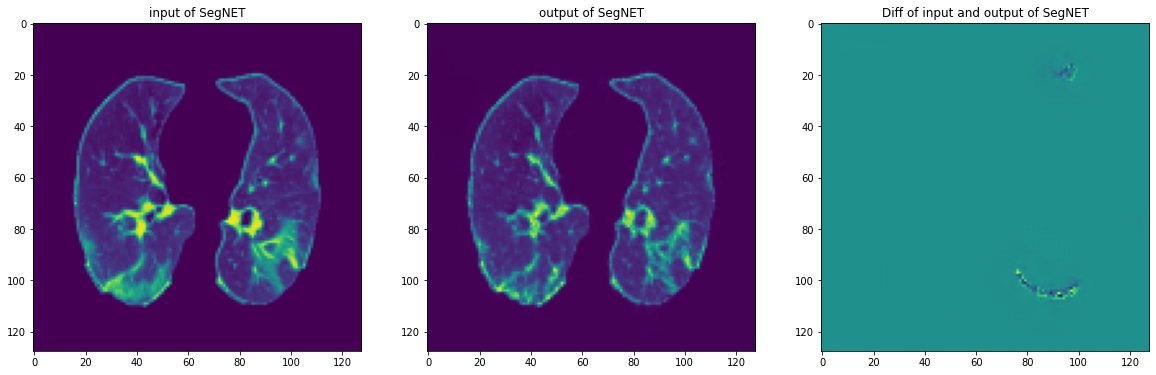

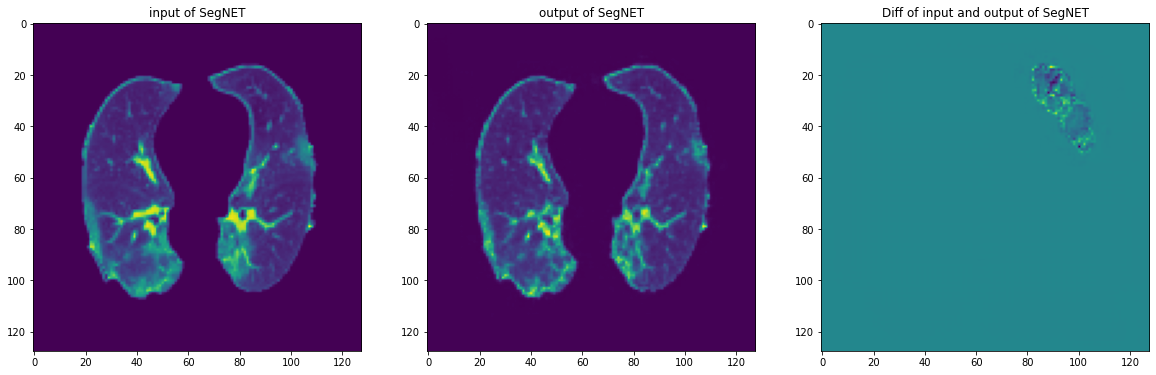

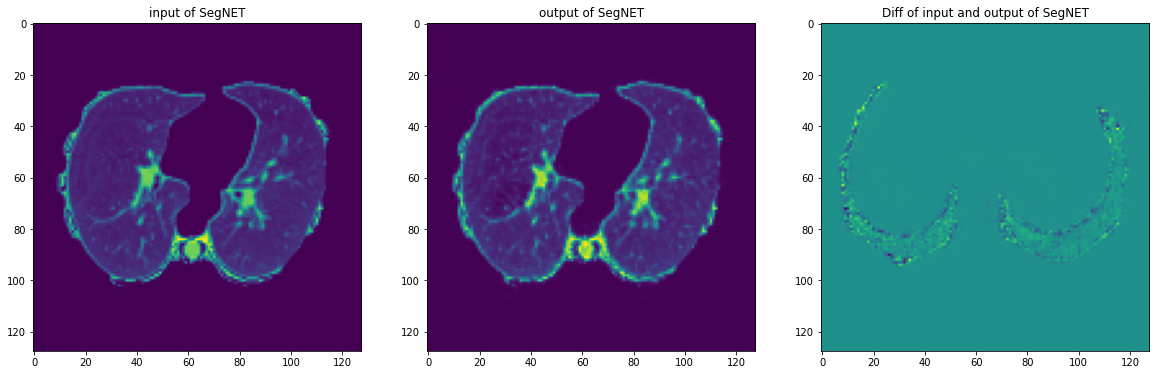

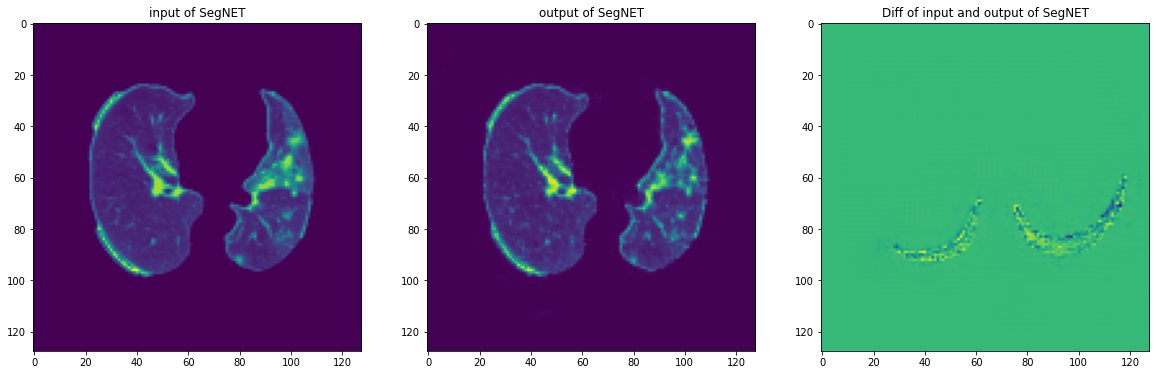

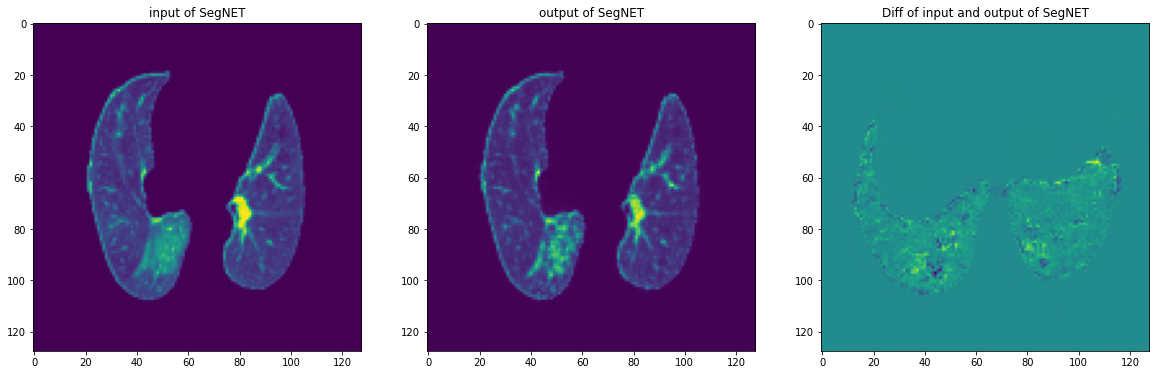

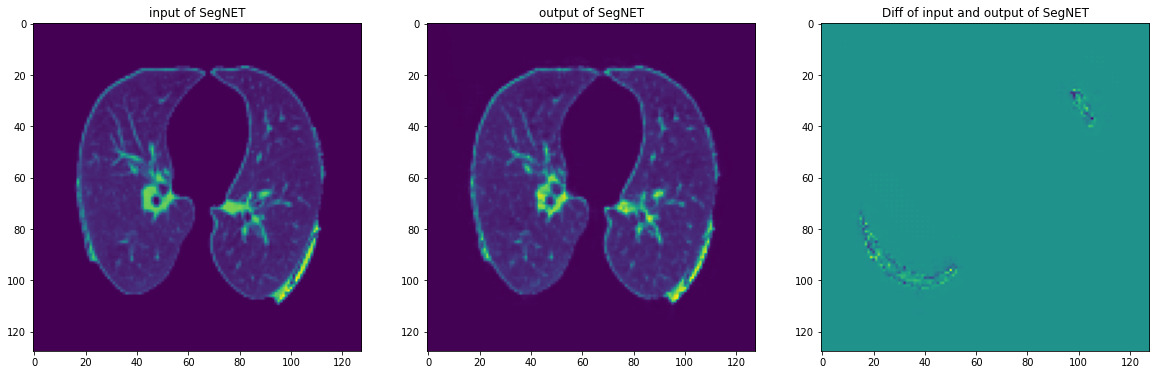

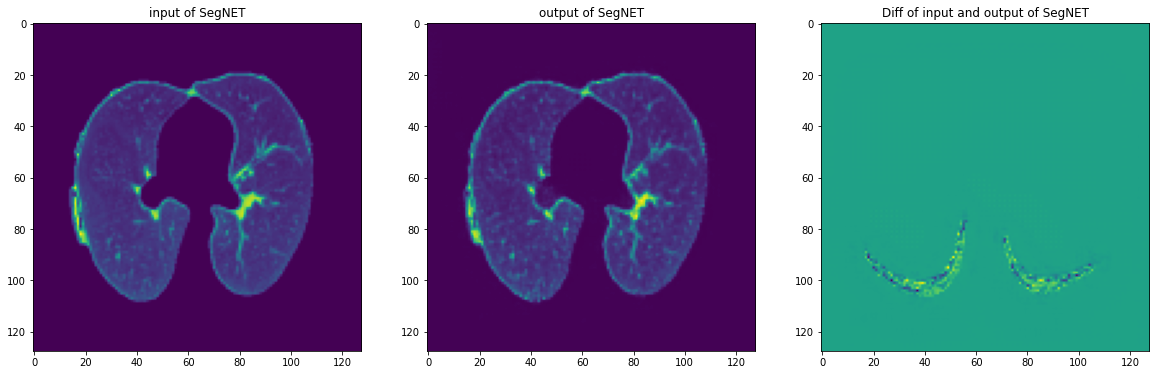

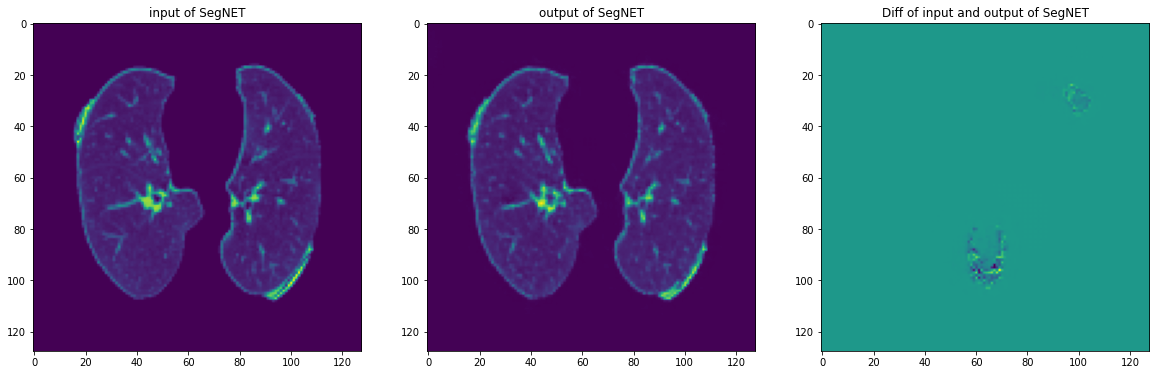

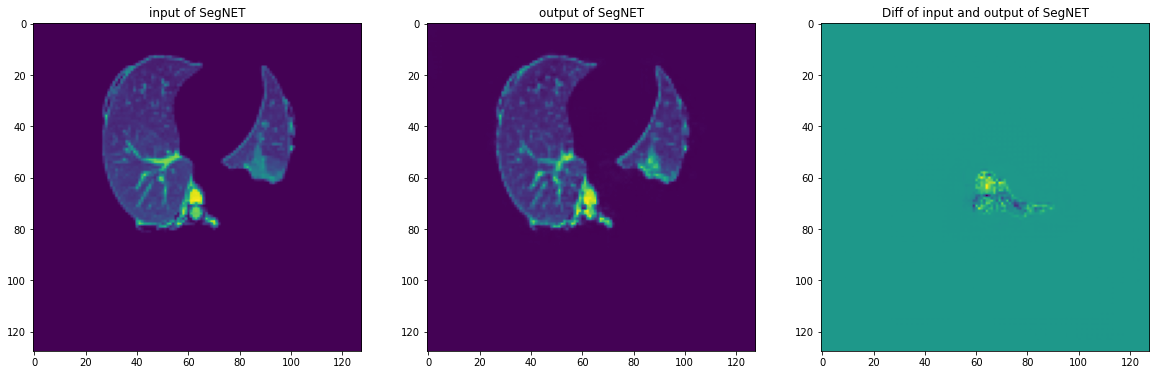

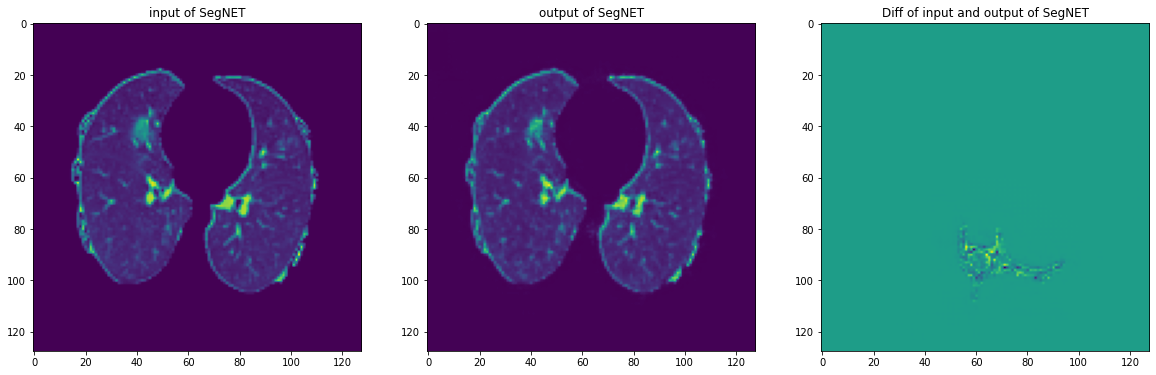

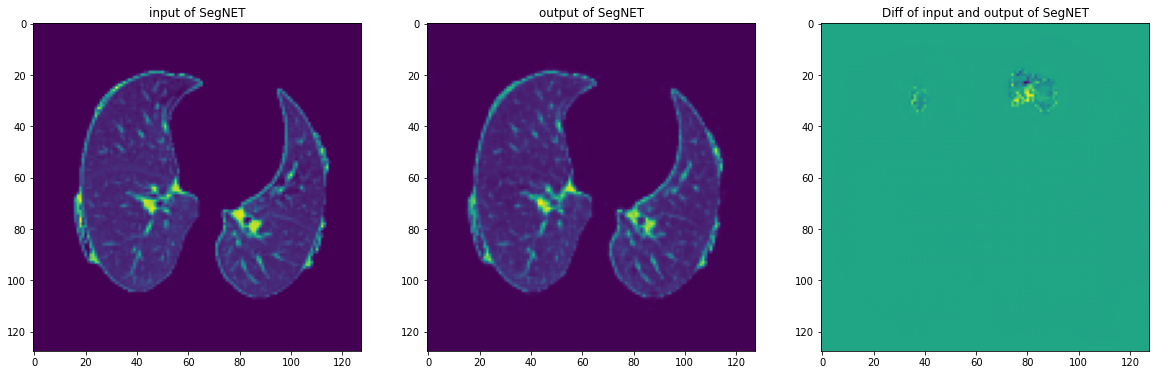

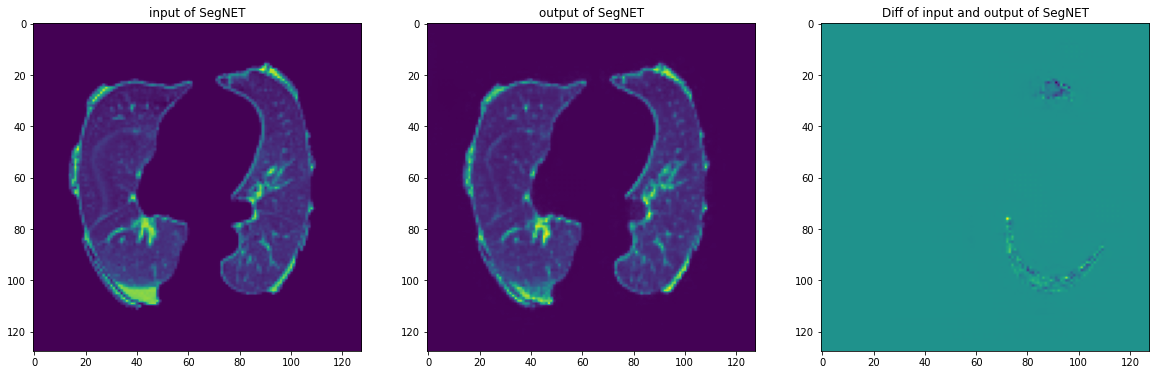

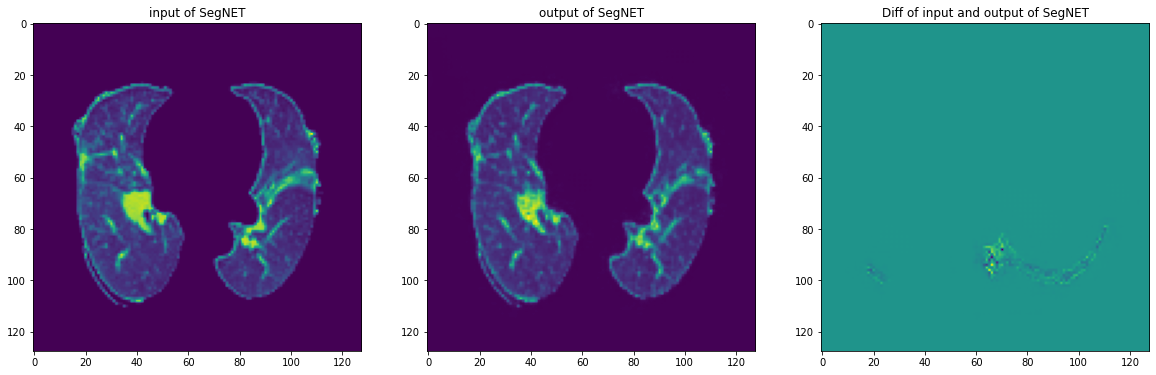

In [11]:
from scipy import signal
from tqdm import tqdm
dataset = np.zeros((len(file_paths),50,128,128))
counter = 0
for j in tqdm(file_paths):
    # print(j)
    CT = np.load(j)
    CT_resized = resize(CT, (CT.shape[0],128, 128),anti_aliasing=True)
    out = model.predict(np.reshape(CT_resized,(CT_resized.shape[0],CT_resized.shape[1],CT_resized.shape[2],1)))
    c = CT_resized-out[:,:,:,0]
    diff = resize(c,(50,128,128))
    dataset[counter] = resize(c,(50,128,128))
    counter +=1
    plt.figure(figsize=(20,12))

    plt.subplot(131)
    plt.title('input of SegNET')
    plt.imshow(CT_resized[int(CT_resized.shape[0]/2),:,:])

    plt.subplot(132)
    plt.title('output of SegNET')
    plt.imshow(out[int(out.shape[0]/2),:,:,0])

    plt.subplot(133)
    plt.title('Diff of input and output of SegNET')
    plt.imshow(c[25,:,:])

Link Net

In [12]:
from __future__ import absolute_import
from __future__ import print_function

import os
import numpy as np

from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization, add
from keras.layers.core import Flatten, Reshape
from keras.models import Model
from keras.regularizers import l2
import keras.backend as K

def _shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[1] / residual_shape[1]))
    stride_height = int(round(input_shape[2] / residual_shape[2]))
    equal_channels = input_shape[3] == residual_shape[3]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[3],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([shortcut, residual])

def encoder_block(input_tensor, m, n):
    x = BatchNormalization()(input_tensor)
    x = Activation('relu')(x)
    x = Conv2D(filters=n, kernel_size=(3, 3), strides=(2, 2), padding="same")(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=n, kernel_size=(3, 3), padding="same")(x)

    added_1 = _shortcut(input_tensor, x)

    x = BatchNormalization()(added_1)
    x = Activation('relu')(x)
    x = Conv2D(filters=n, kernel_size=(3, 3), padding="same")(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=n, kernel_size=(3, 3), padding="same")(x)

    added_2 = _shortcut(added_1, x)

    return added_2

def decoder_block(input_tensor, m, n):
    x = BatchNormalization()(input_tensor)
    x = Activation('relu')(x)
    x = Conv2D(filters=int(m/4), kernel_size=(1, 1))(x)

    x = UpSampling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=int(m/4), kernel_size=(3, 3), padding='same')(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=n, kernel_size=(1, 1))(x)

    return x

def LinkNet(input_shape=(128, 128, 1), classes=1):
    inputs = Input(shape=input_shape)

    x = BatchNormalization()(inputs)
    x = Activation('relu')(x)
    x = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2))(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

    encoder_1 = encoder_block(input_tensor=x, m=64, n=64)

    encoder_2 = encoder_block(input_tensor=encoder_1, m=64, n=128)

    encoder_3 = encoder_block(input_tensor=encoder_2, m=128, n=256)

    encoder_4 = encoder_block(input_tensor=encoder_3, m=256, n=512)

    decoder_4 = decoder_block(input_tensor=encoder_4, m=512, n=256)

    decoder_3_in = add([decoder_4, encoder_3])
    decoder_3_in = Activation('relu')(decoder_3_in)

    decoder_3 = decoder_block(input_tensor=decoder_3_in, m=256, n=128)

    decoder_2_in = add([decoder_3, encoder_2])
    decoder_2_in = Activation('relu')(decoder_2_in)

    decoder_2 = decoder_block(input_tensor=decoder_2_in, m=128, n=64)

    decoder_1_in = add([decoder_2, encoder_1])
    decoder_1_in = Activation('relu')(decoder_1_in)

    decoder_1 = decoder_block(input_tensor=decoder_1_in, m=64, n=64)

    x = UpSampling2D((2, 2))(decoder_1)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=32, kernel_size=(3, 3), padding="same")(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=32, kernel_size=(3, 3), padding="same")(x)

    x = UpSampling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=classes, kernel_size=(2, 2), padding="same")(x)

    model = Model(inputs=inputs, outputs=x)

    return model

In [13]:
model = LinkNet(input_shape=(128, 128, 1), classes=1)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
batch_normalization_29 (BatchNo (None, 128, 128, 1)  4           input_3[0][0]                    
__________________________________________________________________________________________________
activation_29 (Activation)      (None, 128, 128, 1)  0           batch_normalization_29[0][0]     
__________________________________________________________________________________________________
conv2d_46 (Conv2D)              (None, 61, 61, 64)   3200        activation_29[0][0]              
____________________________________________________________________________________________

In [14]:
model.load_weights('/content/drive/My Drive/googledrive_segmentation/weight_half_lung_noisy_linknet.hdf5')

100%|██████████| 15/15 [02:14<00:00,  8.97s/it]


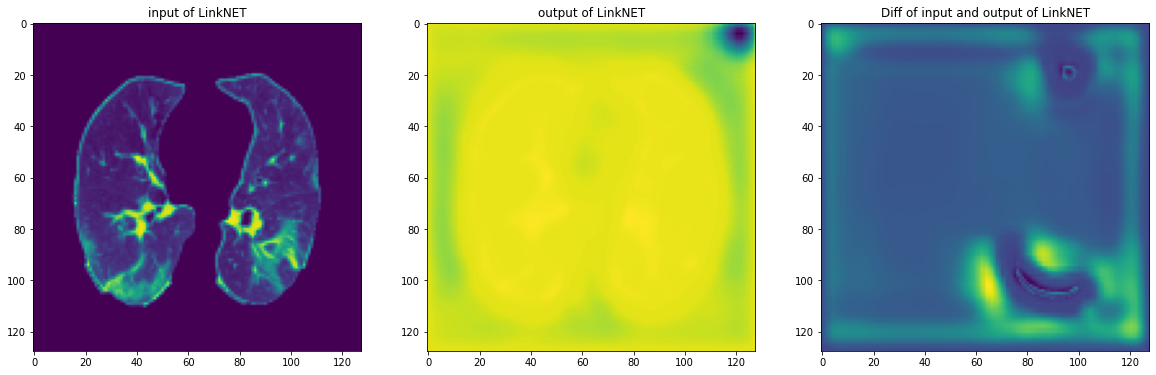

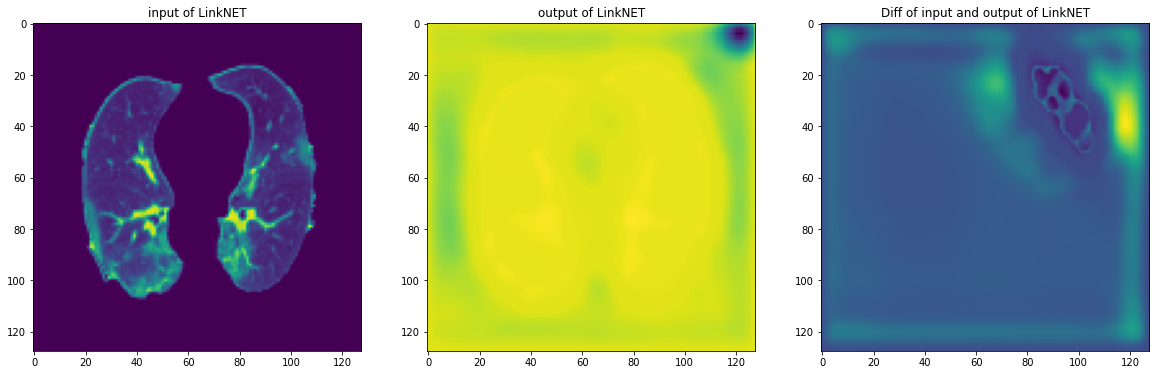

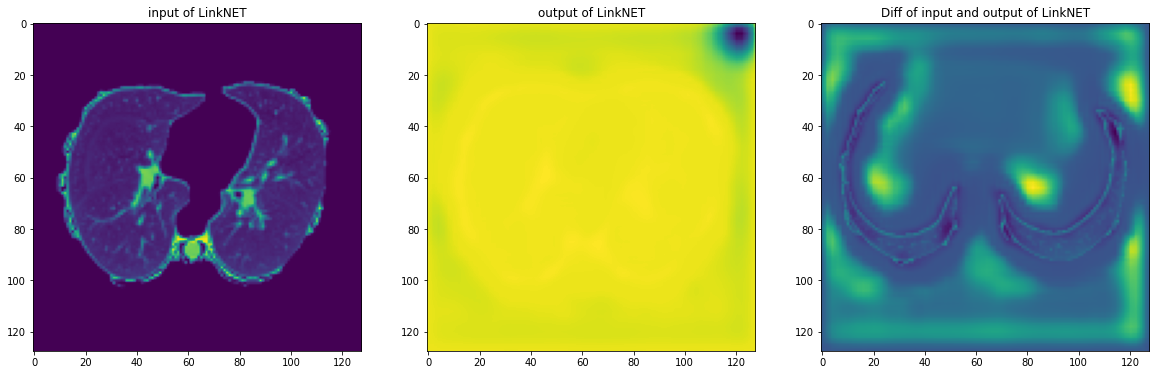

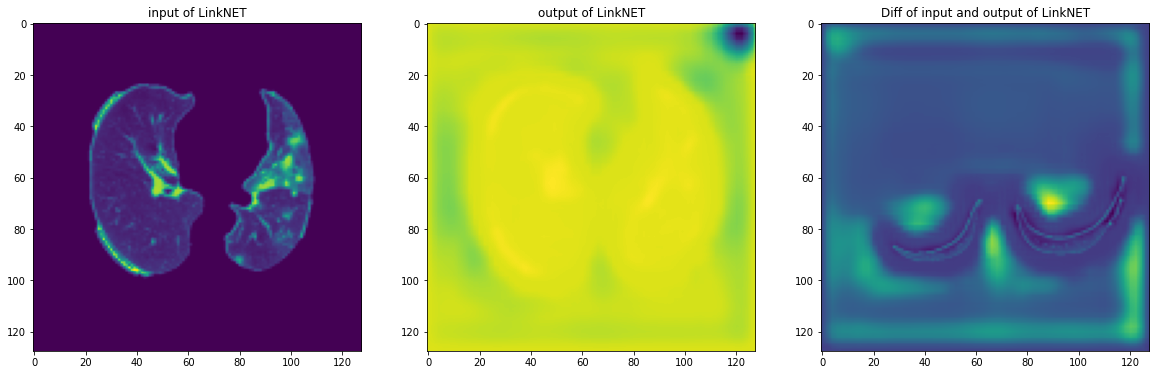

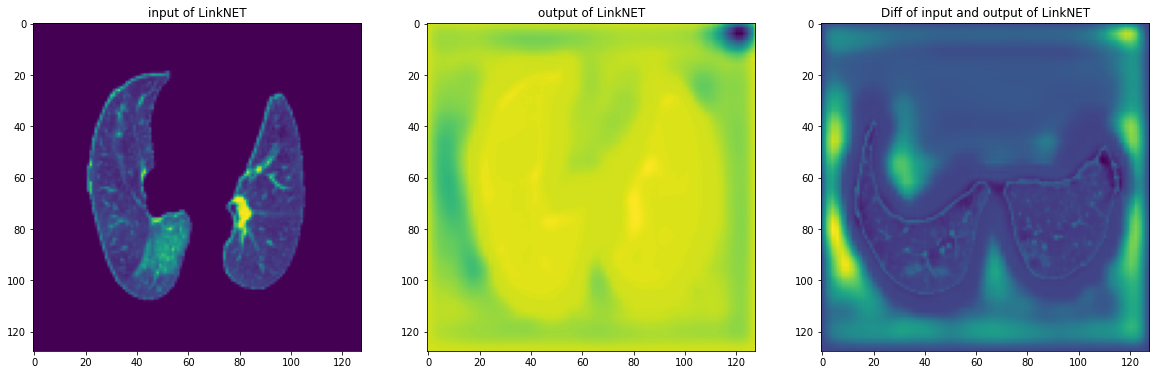

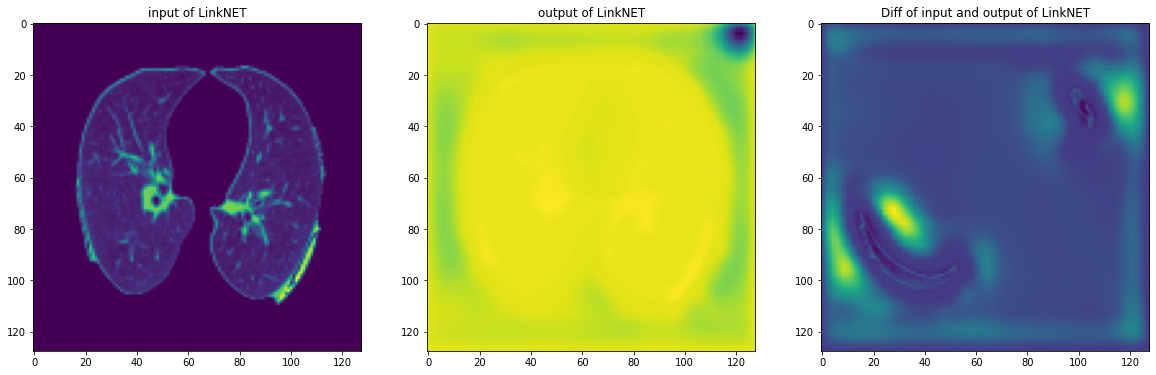

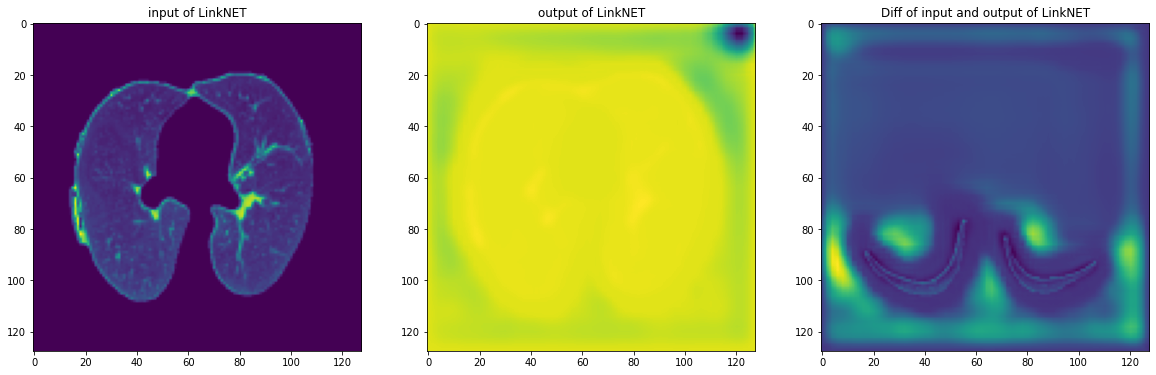

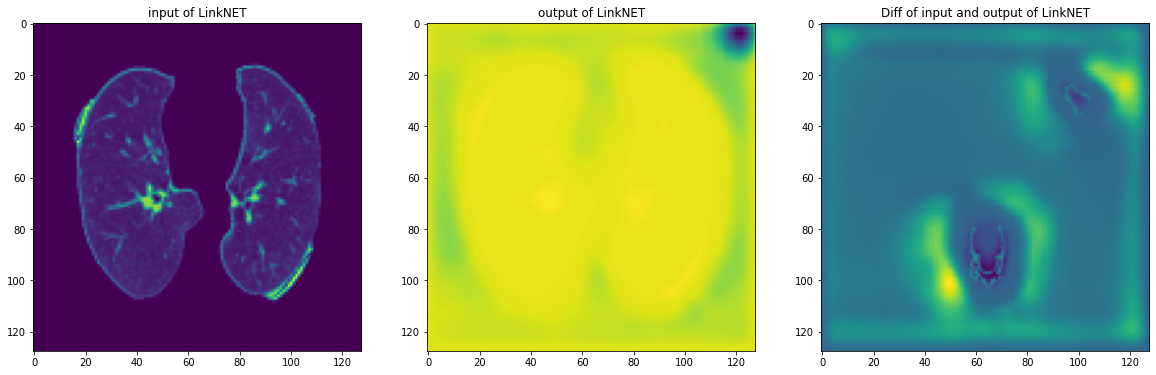

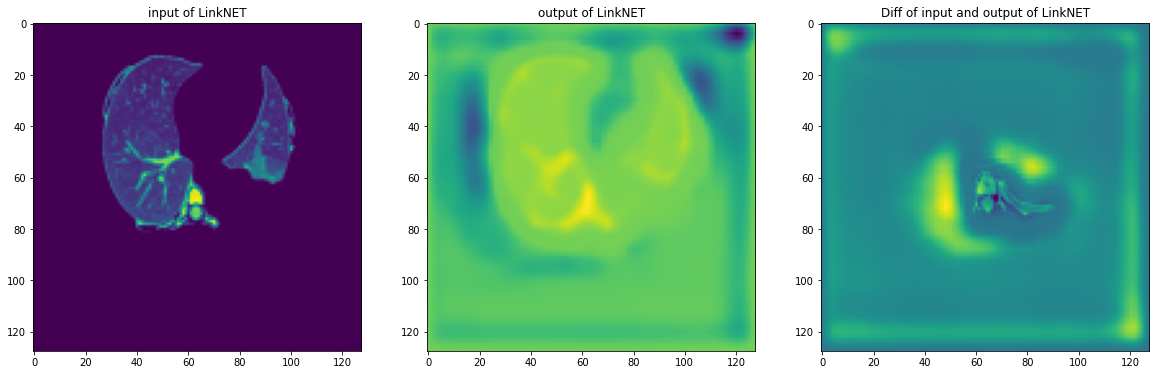

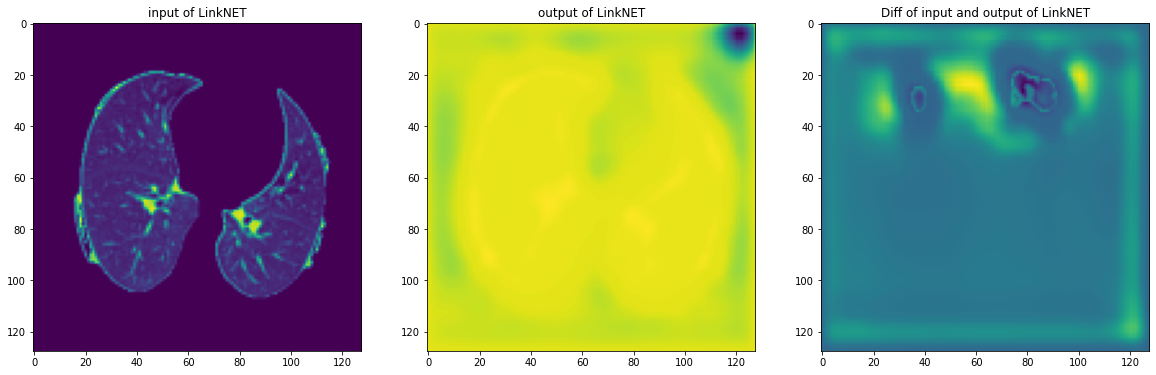

In [15]:
from scipy import signal
from tqdm import tqdm
dataset = np.zeros((len(file_paths),50,128,128))
counter = 0
for j in tqdm(file_paths):
    # print(j)
    CT = np.load(j)
    CT_resized = resize(CT, (CT.shape[0],128, 128),anti_aliasing=True)
    out = model.predict(np.reshape(CT_resized,(CT_resized.shape[0],CT_resized.shape[1],CT_resized.shape[2],1)))
    c = CT_resized-out[:,:,:,0]
    diff = resize(c,(50,128,128))
    dataset[counter] = resize(c,(50,128,128))
    counter +=1
    plt.figure(figsize=(20,12))

    plt.subplot(131)
    plt.title('input of LinkNET')
    plt.imshow(CT_resized[int(CT_resized.shape[0]/2),:,:])

    plt.subplot(132)
    plt.title('output of LinkNET')
    plt.imshow(out[int(out.shape[0]/2),:,:,0])

    plt.subplot(133)
    plt.title('Diff of input and output of LinkNET')
    plt.imshow(c[25,:,:])